In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Genesys POC v2: Allocation strategy

## Definition of the model

The system is modelled as an LTI problem, the variables are the connection between power units and plug units, the input is the maximum power available for the whole system and the power requested by the electric vehicle in each plug unit.
Optimisation is performed by maximising the power delivered by the whole system, taking into account the efficiency of the power units and the number of changes in the connections with respect to the previous iteration.

**Power modules, MPUs:**
$$
i \in I
$$

**Plug modules, PUs:** 
$$
j \in J
$$

Before running the optimizer:

- The available power of each MPU \( P_n(i) \) should be set according to the data from the MPU (considering de-rating).
- The requested power of each EV, \( P_ev(j) \), should be set according to this algorithm:

**If** P_absorbed(j) < P_available in the plug j (sum of the P_n of the connected MPUs):\
    P_ev(j) = P_absorbed(j) + ΔP, where ΔP is an arbitrary increment (maybe the minimum power of MPUs).\
**Else**\
    P_ev(j) = P_absorbed(j)

In [2]:
# Define the model
model = ConcreteModel()

# Sets

# Power modules MPUs
model.i = Set(initialize=['mpu1', 'mpu2', 'mpu3', 'mpu4', 'mpu5', 'mpu6', 'mpu7', 'mpu8', 'mpu9', 'mpu10'])

# Plug modules PUs
model.j = Set(initialize=['pu1', 'pu2', 'pu3', 'pu4', 'pu5'])

## Parameters

Nominal power of the power modules, MPUs:
$$
Pn_i \quad \forall i \in I
$$

Connection of the eletric veicle (0 or 1), EVs:
$$
Cev_j \quad \forall j \in J
$$

Power requested by the eletric veicle, EVs:
$$
Pev_j \quad \forall j \in J
$$

Maximum power from AC side, from the grid:
$$
Pac_{max}
$$

Penalty to consider efficency in the obj function:
$$
K_{eff}
$$

Penalty to consider variations in connection in the obj function:
$$
K_{var}
$$

Availability of the connection between MPU i and PU j:
$$
xAvl_{i,j} \quad \forall i \in I \quad \forall j \in J
$$

Previous connection between MPU i and PU j:
$$
xPrev_{i,j} \quad \forall i \in I \quad \forall j \in J
$$

In [3]:
# Parameters

# Nominal power of the MPUs
model.Pn = Param(model.i, initialize={
    'mpu1': 130, 'mpu2': 70, 'mpu3': 50, 'mpu4': 20, 'mpu5': 50,
    'mpu6': 30, 'mpu7': 100, 'mpu8': 50, 'mpu9': 30, 'mpu10': 60
})

# Connection of the Elettric veicles EVs
model.Cev = Param(model.j, initialize={
    'pu1': 1, 'pu2': 1, 'pu3': 1, 'pu4': 1, 'pu5': 1
})

# Power requested by the Elettric veicles EVs
model.Pev = Param(model.j, initialize={
    'pu1': 160, 'pu2': 70, 'pu3': 80, 'pu4': 130, 'pu5': 80
})

# Maximum power from AC side, from the grid
model.Pacmax = Param(initialize=700)

# Penaltye to consider efficency in the obj function
model.Keff = Param(initialize=1)

# Penaltye to consider variations in connection in the obj function
model.Kvar = Param(initialize=1)

# Availability of the connection between MPUs and PUs
model.x_avl = Param(model.i, model.j, initialize=1, mutable=True)  # Availability of the connection
# Example:
#model.x_avl['mpu10','pu1']=0

# Previous connection between MPUs and PUs
model.x_prev = Param(model.i, model.j, initialize=0, mutable=True)  # Previous state variable

## Variables

Connection between MPU i and PU j:
$$
x_{i,j} \quad \forall i \in I \quad \forall j \in J
$$

Changes in the connections with respect previous connections:
$$
delta_{i,j} \quad \forall i \in I \quad \forall j \in J
$$

Power available on each plug unit j
$$
p_{j}\quad \forall j \in J
$$

In [4]:
# Variables

# Connection between MPUs and PUs
model.x = Var(model.i, model.j, domain=Binary)  # Binary variable for the connection between i and j
model.delta = Var(model.i, model.j, domain=NonNegativeReals)  # Auxiliary variable for absolute difference

# Power delivered by the PUs
model.p = Var(model.j, domain=NonNegativeReals)  # Power delivered to each plug unit j

# Objectve functions, maximize the power delivered
#the efficency is considered adding a penalty in case of non full use of the power available on the plug
model.Ptot = Var(domain=NonNegativeReals)  # Total power delivered
model.NotUsedP = Var(domain=NonNegativeReals)
model.nVar = Var(domain=NonNegativeReals) # Number of variations in connections respect to previous iteration

model.obj = Var(domain=NonNegativeReals)  # objective function to be minimized

## Equations

### Each power unit can be connected to only one plug unit:
$$
\sum_{j \in J} x_{i,j} \leq 1 \quad \forall i \in I
$$

In [5]:
# Each power unit i can be connected to only one plug unit
def singleConnection_rule(model, i):
    return sum(model.x[i, j] for j in model.j) <= 1
model.singleConnection = Constraint(model.i, rule=singleConnection_rule)

### Each plug unit, if the EV is connected, must have at least one power unit connected:
$$
   \sum_{i \in I} x_{i,j} \geq Cev_j \quad \forall j \in J
$$   

In [6]:
# Each plug unit j must have at least one power unit connected
def allConnected_rule(model, j):
    return sum(model.x[i, j] for i in model.i) >= model.Cev[j]
model.allConnected = Constraint(model.j, rule=allConnected_rule)

### The power absorbed by each plug unit j is limited by the power of the connected power units:
$$
\sum_{i \in I} P_{n_i} \cdot x_{i,j} \geq p_j \quad \forall j \in J
$$

In [7]:
# The power absorbed by each plug unit j is limited by the power of the connected power units
def powerAvailable_rule(model, j):
    return sum(model.Pn[i] * model.x[i, j] for i in model.i) >= model.p[j]
model.powerAvailable = Constraint(model.j, rule=powerAvailable_rule)

### The power absorbed by each plug unit j is limited by the power requested by the EV:
$$
p_j \leq P_{\text{ev}_j} \quad \forall j \in J
$$

In [8]:
# The power absorbed by each plug unit j is limited by the power requested by the EV
def poweRequested_rule(model, j):
    return model.p[j] <= model.Pev[j]
model.poweRequested = Constraint(model.j, rule=poweRequested_rule)

### The total absorbed power cannot exceed the maximum available power:
$$
\sum_{j \in J} p_j \leq P_{\text{acmax}}
$$

In [9]:
# The total power absorbed is limited by the maximum available power
def maxPower_rule(model):
    return sum(model.p[j] for j in model.j) <= model.Pacmax
model.maxPower = Constraint(rule=maxPower_rule)

### Availability of the connections:
$$
x_{i,j} \leq xAvl_{i,j} \quad \forall i \in I  \quad \forall j \in J
$$

In [10]:
# Connection availability
def connAvailable_rule(model,i,j):
    return model.x[i,j] <= model.x_avl[i,j]
model.connAvailable = Constraint(model.i,model.j,rule=connAvailable_rule)

### Absolute value of variations in connection:
$$
delta_{i,j} \geq x_{i,j} - xPrev_{i,j} \quad \forall i \in I  \quad \forall j \in J
$$

$$
delta_{i,j} \geq xPrev_{i,j} - xP_{i,j} \quad \forall i \in I  \quad \forall j \in J
$$

In [11]:
def delta_upper_bound_rule(model, i, j):
    return model.delta[i, j] >= model.x[i, j] - model.x_prev[i, j]
model.delta_upper_bound = Constraint(model.i, model.j, rule=delta_upper_bound_rule)

def delta_lower_bound_rule(model, i, j):
    return model.delta[i, j] >= model.x_prev[i, j] - model.x[i, j]
model.delta_lower_bound = Constraint(model.i, model.j, rule=delta_lower_bound_rule)

## Objective functions

### Total power delivered:
$$
P_{tot} = \sum_{j \in J} p_j
$$

In [12]:
# Defines the objective function for total power delivered
def TotalPower_rule(model):
    return model.Ptot == sum(model.p[j] for j in model.j)
model.TotalPower = Constraint(rule=TotalPower_rule)

### Unused power that is allocated to the plug:
$$
P_{\text{NotUsed}} = \sum_{j \in J} ( \sum_{i \in I} P_{n_i} \cdot x_{i,j} ) - p_j
$$

In [13]:
# Unused power that is allocated to the plug
def NotUsedPower_rule(model):
    return model.NotUsedP == sum((sum(model.Pn[i] * model.x[i, j] for i in model.i) - model.p[j]) for j in model.j)
model.NotUsedPower = Constraint(rule=NotUsedPower_rule)

### Number of variations in connection respect to the previous iteration:
$$
N_{\text{Var}}  = \sum_{i \in I} \sum_{j \in J} delta_{i,j}
$$

In [14]:
# Variation in connections
def Variations_rule(model):
    return model.nVar == sum(model.delta[i, j] for i in model.i for j in model.j)
model.Variations = Constraint(rule=Variations_rule)

### Object function: total power delivered considering efficiency and variations:
$$
Obj = P_{tot} - K_{\text{eff}} \cdot P_{\text{NotUsed}} - K_{\text{var}} \cdot N_{\text{Var}} 
$$

In [15]:
# Defines the objective function considering efficiency
def obj_rule(model):
    return model.obj == model.Ptot - model.Keff * model.NotUsedP - model.Kvar * model.nVar
model.Obj= Constraint(rule=obj_rule)

## Maximize the objective function

In [16]:
# Objective function to maximize the total power delivered considering efficiency
model.obj = Objective(expr=model.obj, sense=maximize)

# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model, tee=True)

'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\ETI\AppData\Local\Temp\tmphlizfd93.glpk.raw --wglp C:\Users\ETI\AppData\Local\Temp\tmpc66soijf.glpk.glp
 --cpxlp C:\Users\ETI\AppData\Local\Temp\tmpx7tirqcw.pyomo.lp
Reading problem data from 'C:\Users\ETI\AppData\Local\Temp\tmpx7tirqcw.pyomo.lp'...
C:\Users\ETI\AppData\Local\Temp\tmpx7tirqcw.pyomo.lp:1192: warning: lower bound of variable 'x4' redefined
C:\Users\ETI\AppData\Local\Temp\tmpx7tirqcw.pyomo.lp:1192: warning: upper bound of variable 'x4' redefined
180 rows, 109 columns, 532 non-zeros
50 integer variables, all of which are binary
1242 lines were read
Writing problem data to 'C:\Users\ETI\AppData\Local\Temp\tmpc66soijf.glpk.glp'.

## Save the previous connections:

$$
 xPrev_{i,j} = x_{i,j} \quad \forall i \in I  \quad \forall j \in J
$$

In [17]:
for i in model.i:
    for j in model.j:
        model.x_prev[i, j] = model.x[i, j].value

## Print results

In [18]:
# Print results
print("Optimal value of objective function:", model.obj())
print("\n")
print("Total power delivered:", model.Ptot())
print("Not used power:", model.NotUsedP())
print("Number of variations:", model.nVar())
print("\n")

for i in model.i:
    print(f"Pn[{i}] = {model.Pn[i]}")

print("\n")
for j in model.j:
    print(f"Power on the PU p[{j}] = {model.p[j].value}" + f"\tRequested Pev[{j}] = {model.Pev[j]}")
print("\n")

Optimal value of objective function: 512.0


Total power delivered: 520.0
Not used power: 0.0
Number of variations: 8.0


Pn[mpu1] = 130
Pn[mpu2] = 70
Pn[mpu3] = 50
Pn[mpu4] = 20
Pn[mpu5] = 50
Pn[mpu6] = 30
Pn[mpu7] = 100
Pn[mpu8] = 50
Pn[mpu9] = 30
Pn[mpu10] = 60


Power on the PU p[pu1] = 160.0	Requested Pev[pu1] = 160
Power on the PU p[pu2] = 70.0	Requested Pev[pu2] = 70
Power on the PU p[pu3] = 80.0	Requested Pev[pu3] = 80
Power on the PU p[pu4] = 130.0	Requested Pev[pu4] = 130
Power on the PU p[pu5] = 80.0	Requested Pev[pu5] = 80




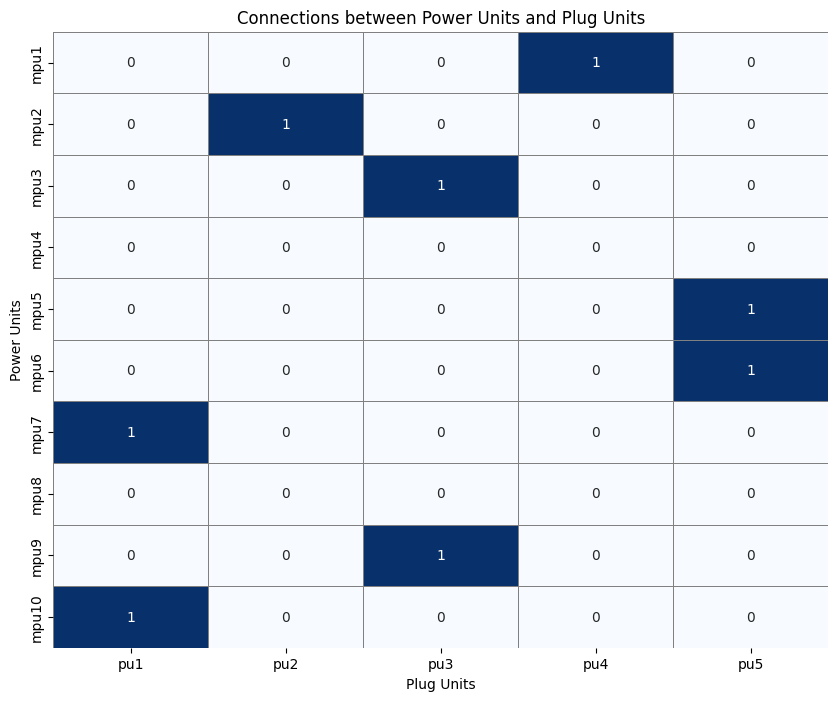

In [19]:
# Create a matrix for the table
matrix = []
for i in model.i:
    row = []
    for j in model.j:
        row.append(model.x[i, j].value)
    matrix.append(row)

# Create a DataFrame
df = pd.DataFrame(matrix, index=model.i, columns=model.j)
# Filter the DataFrame to show only the connections (values == 1)
df_filtered = df[df == 1].fillna(0).astype(int)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_filtered, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='grey')

plt.title('Connections between Power Units and Plug Units')
plt.xlabel('Plug Units')
plt.ylabel('Power Units')
plt.show()